 <html>
<head><center>
<h1>Predicting Forex Data Using Recurrent Neural Network Deep Sequence Modeling </b></h1>
<br>
<img src="https://i.ibb.co/jh6qD0t/RNN.png" alt="RNN" border="0"></a>
</center>
</head>

<html>

### **IMPORTING LIBRARIES**

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

#Install Stock API Client (forex aggregates not currently implemented however I addressed the issue and waiting for them to get back to me. Using requests for now)
!pip install --upgrade --force-reinstall polygon-api-client
!pip install requests
!pip install matplotlib

#Import other packages
from polygon import RESTClient
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import io
import time
import random
import datetime
import functools
import csv
import glob
from google.colab import drive
from tqdm import tqdm
from IPython import display as ipythondisplay

  Using cached polygon_api_client-0.2.11-py3-none-any.whl (22 kB)
  Using cached websockets-10.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (111 kB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached websocket_client-1.2.3-py3-none-any.whl (53 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached urllib3-1.26.8-py2.py3-none-any.whl (138 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-2.0.10-py3-none-any.whl (39 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.8
    Uninstalling urllib3-1.26.8:
      Successfully uninstalled urllib3-1.26.8
  Attempting uninstall: idna
    Found existing installation: idna 3.3
    Uninstalling idna-3.3:
      Successfully uninstalled idna-3.3
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 2.0.10
    Uninstalling charset-normalizer-2

# **1 DATA PREPROCESSING AND CLEAN UP**

### **1.1 TWO FUNCTIONS: ONE TO ACCESS POLYGON API, ANOTHER TO CONVERT TIME STAMP FOR A DATA POINT.**
From 2010-01 to 2020-12 A total 120 Months.
The function access the Polygon API in 1 hour timeframes in a span of a month.
Each Monthly Batch comes in as a JSON file which is converted to a pandas DataFrame then converted into a CSV file.

<html>
<head>
<img src="https://i.ibb.co/XpsFbSH/Polygon.png" alt="Polygon" border="0"></a>
</head>

<html>

In [2]:
def ts_to_datetime(ts) -> str:
  return datetime.datetime.fromtimestamp(ts / 1000.0).strftime('%Y-%m-%d %H:%M')

def print_csv(start, end, year, month):
  # API key
  key = #PUT API KEY FROM POLYGON HERE#  

  endpoint = 'https://api.polygon.io/v2/aggs/ticker/C:GBPJPY/range/1/hour/{dfrom}/{to}?apiKey={key}&limit=50000'
  resp = requests.get(endpoint.format(dfrom = start, to = end, key = key ))

  my_dictionary = {'t': [' '], 'o': [0.0] , 'h': [0.0], 'l': [0.0], 'c': [0.0], 'v': [0.0], 'vw': [0.0], 'avgOHLC': [0.0]}

  for result in resp.json()['results']:
    dt = ts_to_datetime(result["t"])
    avgOHLC = (result['o'] + result['h'] + result['l'] + result['c']) / 4

    my_dictionary['t'].append(dt)             # Time
    my_dictionary['o'].append(result['o'])    # Open Price
    my_dictionary['h'].append(result['h'])    # High Price
    my_dictionary['l'].append(result['l'])    # Low Price
    my_dictionary['c'].append(result['c'])    # Close Price
    my_dictionary['v'].append(result['v'])    # Volume
    my_dictionary['vw'].append(result['vw'])  # Volume Weighted
    my_dictionary['avgOHLC'].append(avgOHLC)  # Average Price

  # converts dictionary to pandas DataFrame
  df = pd.DataFrame(my_dictionary)            
  
  filename = "/drive/My Drive/CSV2/" + year + "-" + month + ".csv"

  # converts pandas DataFrame into a csv file
  df.to_csv(filename)

### **1.2 SCRIPT FOR AUTOMATING A TIMELINE OF 10 YEARS MONTHLY API CALLS**
Resulting in 120 Monthly CSV Files with each file containing 1 hour data points in a span of a month.

In [3]:
# specify training data timeline: 10 years
# from 2010 to 2020

import datetime
import calendar

year = 2010
month = 1

for i in range(0, 11):

  for j in range(0, 12):
    _, num_days = calendar.monthrange(year + i, month + j)

    start_day = datetime.date(year + i, month + j, 1)
    end_day = datetime.date(year + i, month + j, num_days)

    print_csv(start_day, end_day, str(year + i), str(month + j))


FileNotFoundError: ignored

### **1.3 CONCATENATING ALL 120 MONTHLY CSV FILES INTO ONE CSV FILE.**
The resulting csv file has 68,293 data points from 2010-01 to 2020-12 in 1 hour time frames.

In [ ]:
cwd = os.getcwd()

os.chdir('/drive/My Drive/CSV2/')

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# combines all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
# export to csv
combined_csv.to_csv( "forexDataGBPJYP.csv", index=False, encoding='utf-8-sig')

### **1.4 UPLOADING CSV FILE**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FOREXdataGBP-JYP.csv to FOREXdataGBP-JYP (1).csv


## **1.5 DATA PREPROCESSING FOR MODEL**

To start processing, we define a function to convert UNIX timestamps that the Polygon API returns to dates and define the API key as well as all vectors we will use for data collection and preprocessing.

In [4]:
#timestamp to datetime converter as polygon returns timestamps
def ts_to_datetime(ts) -> str:
  return datetime.datetime.fromtimestamp(ts / 1000.0).strftime('%Y-%m-%d %H:%M')
#Define the key for API and initialize all Vectors to be used for processing
key_ = #PUT API KEY FROM POLYGON HERE#    
dateVector = []
ohlcVector = []

### **1.6 DATA SELECTION**

#### **1.7 OPTIONAL CELL TO FETCH DATA FROM API INSTEAD OF DATABASE**
Run this cell to populate the ohlcVector with average OHLC (open, high, low,  close) prices  obtained from the API. This works the best with daily data due to the way the Polygon API aggregates prices and allows for the flexibility of choosing any currency pair 

In [5]:
from_ = "2009-10-01"
to_ = "2020-05-01"
endpoint = 'https://api.polygon.io/v2/aggs/ticker/C:USDJPY/range/1/day/{dfrom}/{to}?unadjusted=true&sort=asc&apiKey={key}&limit=50000'
resp = requests.get(endpoint.format(dfrom = from_, to = to_, key = key_ ))
for result in resp.json()['results']:  
    dt = ts_to_datetime(result["t"])
    avgOHLC = (result['o'] + result['h'] + result['l'] + result['c']) / 4
    dateVector.append(dt[5:])
    ohlcVector.append(float(avgOHLC))

#### **1.8.1 CELL TO FETCH DATA FROM UPLOADED FILE OR DATABASE**
If the cell above was not run, run this cell to use data from an uploaded csv file or database. This was necessary as we had to write a script to concatenate all 4 hour data and 1 hour data for a given currency from the API due to restrictions with how data is aggregated on the API side.

In [6]:
#Create price difference vector to be used as input
df2 = pd.read_csv(io.BytesIO(uploaded['FOREXdataGBP-JYP.csv'])) 
ohlcVector = df2['avgOHLC'].tolist()

NameError: ignored

### **1.8.2 FETCH DATA FROM MONGODB MLAB DATABASE**

In [ ]:

from pymongo import MongoClient
from pprint import pprint 

mongo_client = MongoClient(#MONGO CREDENTIALS HERE IF APPLICABLE#)

# database name
db = mongo_client["DataMining2021"]
# collection name
col = db["4HRGBPYEN"]

result = col.find()

openValue = []
highValue = []
lowValue = []
closeValue = []
avgOHLCValue = []
for doc in col.find():
    openValue += [doc["1"]]
    highValue += [doc["2"]]
    lowValue += [doc["3"]]
    closeValue += [doc["4"]]
    avgOHLCValue += [doc["7"]]

print("avgOHLCValue: ", closeValue)

# **2 PRICE PREDICTION OVER TIME MODEL**

### **2.1 GENERATING CHANGES IN PRICE AND SPLITTING DATA FOR TRAINING AND TESTING**
Instead of using prices as inputs to our model, which are sensitive to trends due to time, we use percent changes in price which do not change as prices go up or down. This also helps to provide bounds to the data. For our splitting of the data, we use a standard 80/20 split between training and testing data.  

In [7]:
dpriceVector = []
for i in range(0,len(ohlcVector)-1):
  dpriceVector.append(float('{:.7f}'.format(((ohlcVector[i+1]-ohlcVector[i])/ohlcVector[i])))*100)
vocab_size = len((set(dpriceVector)))
print("TOTAL SIZE:", len(dpriceVector))
print("There are", vocab_size, "unique characters in the dataset")
split_point = int(len(dpriceVector)*0.8)
trainingData = dpriceVector[:split_point]    
testData = dpriceVector[split_point:]
trainingData_len = len(trainingData)
testData_len = len(testData)


TOTAL SIZE: 3301
There are 3254 unique characters in the dataset


### **2.3 SHAPING DATA FOR MODEL**
The idea for our model is that it takes a sequence of percent changes in price and tries to predict the next percent change. Therefore, the input for our model needs to be a list of percent change sequences and our output will be a list of what the next percent change should be. Since we need to define the sequence length, we will define this function now and use it later when we define hyperparameters.

In [ ]:
def createTrainingBatch(seq_length):
  x_train = []
  y_train = []
  for x in range(seq_length, trainingData_len):
    x_train.append(trainingData[x-seq_length:x])
    y_train.append(trainingData[x])
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  return x_train, y_train

## **2.4 BUILDING THE MODEL**

<html>
<head>
<h1>Recurrrent Neural Network using Long Short Term Memory (LSTM) </b></h1>
<br>
<img src="https://i.ibb.co/y5FDfpW/LSTM.png" alt="LSTM" border="0">
<img src="https://i.ibb.co/v1cFZch/LSTM5.png" alt="LSTM5" border="0">
<img src="https://i.ibb.co/6bMHPN2/Many-To-One.png" alt="Many-To-One" border="0">
</head>

<html>

### **2.4.1 MODEL ARCHITECTURE**
This function defines the architecture our model uses. We stack 3 LSTMs to provide layers of abstraction that allow the model to create its own intermediary data from which it will generate a prediction through the final dense layer with 1 output. We placed dropout layers between each LSTM layer to help prevent overfitting. The Model uses 1 dense layer.

In [ ]:
def build_model(rnn_units, input_shape_):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, input_shape=input_shape_),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(rnn_units),
    tf.keras.layers.Dense(1)
  ])
  return model

### **2.4.2 SUMMARY OF A SAMPLE MODEL**

In [ ]:
model = build_model(256, (250, 1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 250, 256)          264192    
_________________________________________________________________
dropout_12 (Dropout)         (None, 250, 256)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 250, 256)          525312    
_________________________________________________________________
dropout_13 (Dropout)         (None, 250, 256)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
____________________________________________

### **2.4.3 DEFINING HYPERPARAMETERS**

In [ ]:
# Optimization parameters:
num_epochs = 120
batch_size_ = 32  
seq_length = 125 
learning_rate = 1e-5 

# Model parameters: 
rnn_units = 150  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### **2.4.4 TRAINING THE MODEL**

<html>
<head>
<h1>Training the Model: Backpropagation Through Time </b></h1>


<br>
<img src="https://i.ibb.co/LppKzzW/RNNBack-Prop.png" alt="RNNBack-Prop" border="0"></a>
</head>

<html>

In [ ]:
#generate the training batch 
x_train,y_train = createTrainingBatch(seq_length)
#build the model
model = build_model(rnn_units, (x_train.shape[1],1))
#define optimizer and loss function
model.compile(optimizer='Adam', loss='mean_squared_error')
#fit the model to the data
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size_)

Epoch 1/120
79/79 [==============================] - 5s 23ms/step - loss: 0.1665
Epoch 2/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1768
Epoch 3/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1433
Epoch 4/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1244
Epoch 5/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1357
Epoch 6/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1303
Epoch 7/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1367
Epoch 8/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1315
Epoch 9/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1271
Epoch 10/120
79/79 [==============================] - 2s 21ms/step - loss: 0.1423
Epoch 11/120
79/79 [==============================] - 2s 22ms/step - loss: 0.1364
Epoch 12/120
79/79 [==============================] - 2s 22ms/step - loss: 0.1344
Epoch 13/120
79/79 [=====

### **2.4.8 PLOTTING THE LOSS THROUGHOUT TRAINING**

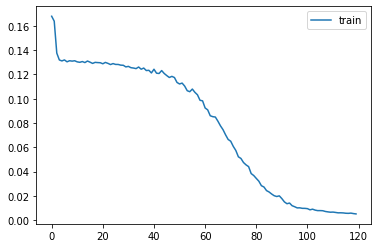

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# **3 TESTING THE MODEL**

### **3.1 TEST DATA GENERATION**
Since LSTMs rely on developing a hidden state from seeing earlier data, we will have to concatenate the testing data to the training data to see how well the model is able to continue predicting the market

In [ ]:
generation_length = 10
x_test = []
for x in range(seq_length,len(dpriceVector[0:-(generation_length)])):
  x_test.append(dpriceVector[x-seq_length:x])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### **3.2 PRICE PREDICTION**
One problem we saw with many model online is how they handle prediction. Since the goal is predicting prices into the future, the model should be making prediction based off its own predictions. Many online models simply run the model on the test data which does not accomplish this.

In [ ]:
predicted_price = []
for i in range(0,generation_length):
  predicted_price = model.predict(x_test)
  print(predicted_price[-1][0])
  add_price = float('{:.6f}'.format(predicted_price[-1][0]))
  x_test_copy = x_test.copy()
  np.squeeze(x_test_copy)
  x_test_copy = np.append(x_test_copy,add_price)
  new_data_sequence = x_test_copy[(0-seq_length):]
  new_data_sequence = new_data_sequence.reshape(1,seq_length,1)
  x_test = np.concatenate((x_test,new_data_sequence))
predicted_prices = [predicted_price[i] for i in range(0,len(predicted_price))]

0.21962304
0.028732631
-0.07184302
0.09874011
0.37697032
0.4407034
0.16559133
-0.05561822
0.1524803
0.27058858


### **3.3 CONVERTING PERCENT PRICE CHANGES BACK TO ACTUAL PRICES**
Since our model outputs percent changes in price, we must convert this back to actual prices given a starting price. 

In [ ]:
calculatedOriginalPrices = []
calculatedOriginalPrices.append(ohlcVector[seq_length])
for i in range(seq_length,len(dpriceVector)):
  nextPriceOriginal = calculatedOriginalPrices[i-seq_length] * ((dpriceVector[i])/100+1)
  calculatedOriginalPrices.append(nextPriceOriginal)
calculatedPredictedPrices = []
calculatedPredictedPrices.append(ohlcVector[seq_length])  
for i in range(0,len(predicted_prices)):
  nextPricePredicted = calculatedPredictedPrices[i] * ((predicted_prices[i])/100+1)
  calculatedPredictedPrices.append(nextPricePredicted)

### **3.4 VISUALIZING THE RESULTS**

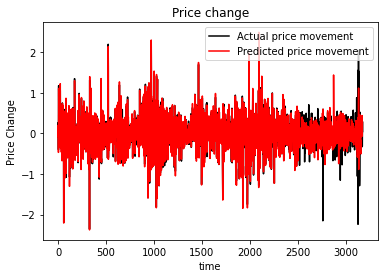

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


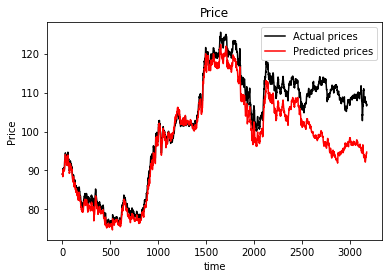

In [ ]:
plt.plot(dpriceVector[seq_length:], color='black', label="Actual price movement")
plt.plot(predicted_prices, color='red', label="Predicted price movement")
plt.title("Price change")
plt.xlabel('time')
plt.ylabel("Price Change")
plt.legend()
plt.show()
plt.plot(calculatedOriginalPrices, color='black', label="Actual prices")
plt.plot(calculatedPredictedPrices, color='red', label="Predicted prices")
plt.title("Price")
plt.xlabel('time')
plt.ylabel("Price")
plt.legend()
plt.show()


# **4 SHORT TERM CATEGORICAL PRICE PREDICTION MODEL**
After experimenting with the price prediction over time model, we came to the conclusion that predicting prices over the long term is not feasible given the amount of external variables at play that compound over time. Instead, we decided to pursue a model that could be used as more of a trading tool. Based on previous prices, we try to predict whether the price will be moving up or down in the next time frame and how big will the movement be. Because the output is categorical, the model will also be able to provide confidence metric which we could leverage to find optimal times to enter the market.

### **4.1 VISUALIZING TRAINING DATA THROUGH A HISTOGRAM**

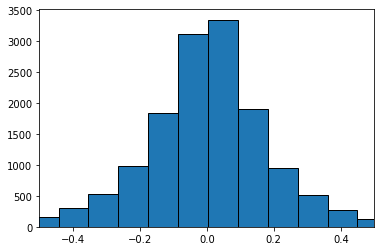

In [ ]:
plt.hist(trainingData, edgecolor="black",bins=100)
plt.xlim(-0.5,0.5)
plt.show()

## **4.2 DATA PREPROCESSING**

### **4.3 VECTORIZING OUTPUTS AND SHAPING DATA FOR MODEL**
Since we will be predicting categories of price movement, we must define what is considered a big, medium, and small movement. We first accomplished this by simply visualizing the data through a histogram and picking the appropriate cutoffs. These are the values we settled on for 4-hour data.

0.  -> Big Move Down (:-2]
1.  -> Medium Move Down (-2:-0.75]
2.  ->Small Move Down (-0.75:0)
3.  ->Small Move Up (0:0.75) 
4.  ->Medium Move Up [0.75:2)
5.  ->Big Move Up [0.2:)
6.  ->No movement 0.0


In [ ]:
def createCategoricalTrainingBatch(seq_length):
  x_train = []
  y_train = []
  #print(np.average(trainingData))
  high_cutoff = 0.97*np.std(trainingData)
  medium_cutoff = 0.35*np.std(trainingData)
  for x in range(seq_length, trainingData_len):
    x_train.append(trainingData[x-seq_length:x])
    if trainingData[x] <= -(high_cutoff):
      y_train.append(0)
    elif trainingData[x] <= -(medium_cutoff) and trainingData[x] > -high_cutoff:
      y_train.append(1)
    elif trainingData[x] < 0 and trainingData[x] > -(medium_cutoff):
      y_train.append(2)
    elif trainingData[x] > 0 and trainingData[x] < medium_cutoff:
      y_train.append(3)
    elif trainingData[x] >= medium_cutoff and trainingData[x] < high_cutoff:
      y_train.append(4)
    elif trainingData[x] >= high_cutoff:
      y_train.append(5)
    else:
      y_train.append(6)

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  return x_train, y_train;

# **5 BUILDING THE MODEL**

### **5.1 MODEL ARCHITECTURE**
Our model for the cateogrical predictions is very similar to our initial model for price predictions over time. The big exception is that the output dense layer now has 7 outputs for each of the categories we defined.

<html>
<head>
<h1>Recurrrent Neural Network using Categorical Data </b></h1>
<br>
<img src="https://i.ibb.co/y5FDfpW/LSTM.png" alt="LSTM" border="0">
<img src="https://i.ibb.co/v1cFZch/LSTM5.png" alt="LSTM5" border="0">
<img src="https://i.ibb.co/xFjgXk0/Many-To-Many.png" alt="Many-To-Many" border="0">
</head>

<html>

In [ ]:
#CHANGED MODEL NEEDS TO HAVE A DENSE LAYER EQUAL TO NUMBER OF CATEGORIES WE MADE
def build_model(rnn_units, seq_length):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, input_shape=(seq_length,1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(rnn_units),
    tf.keras.layers.Dense(7)
  ])
  return model

###Categories:
* Big Move Down
* Medium Move Down
* Small Move Down
* No Movement
* Small Move Up
* Medium Move Up
* Big Move Up


### **5.2 DEFINING HYPERPARAMTERS**

In [ ]:
# Optimization parameters:
num_epochs_categorical = 300  
batch_size_categorical = 32  
seq_length_categorical = 900  
learning_rate_categorical = 1e-5 

# Model parameters: 
rnn_units_categorical = 512 

# Checkpoint location: 
checkpoint_dir_categorical = './training_checkpoints_categorical'
checkpoint_prefix = os.path.join(checkpoint_dir_categorical, "my_ckpt")

### **5.3 GENERATING THE CATEGORICAL TRAINING BATCH**

In [ ]:
x_train, y_train = createCategoricalTrainingBatch(seq_length_categorical)

0.00042010232300884965


### **5.4 VISUALIZING CATEGORY DISTRIBUTION**

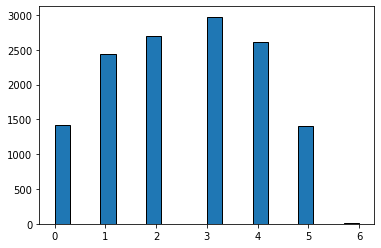

In [ ]:
plt.hist(y_train, edgecolor="black",bins=20)
plt.show()

### **5.5 TRAINING THE MODEL**
We train the model in much the same way as we trained the price prediction over time model except that we are using the Adamax optimizer which is more suited for categorical data and we are using Sparse Categorical Cross Entropy as the loss function (ensuring it applies a softmax over outputs before calculations are done with from_logits=True). 

In [ ]:
model = build_model(rnn_units_categorical, seq_length_categorical)
model.compile(optimizer='Adamax', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(x_train, y_train, epochs=num_epochs_categorical, batch_size=batch_size_categorical)
model.save_weights(checkpoint_prefix)
files.download('/content/training_checkpoints_categorical/*')

Epoch 1/300
424/424 [==============================] - 106s 245ms/step - loss: 1.7640
Epoch 2/300
424/424 [==============================] - 107s 252ms/step - loss: 1.7357
Epoch 3/300
424/424 [==============================] - 108s 254ms/step - loss: 1.6913
Epoch 4/300
424/424 [==============================] - 109s 257ms/step - loss: 1.6507
Epoch 5/300
424/424 [==============================] - 112s 264ms/step - loss: 1.6409
Epoch 6/300
424/424 [==============================] - 113s 267ms/step - loss: 1.6328
Epoch 7/300
424/424 [==============================] - 114s 268ms/step - loss: 1.6274
Epoch 8/300
424/424 [==============================] - 114s 268ms/step - loss: 1.6240
Epoch 9/300
424/424 [==============================] - 113s 267ms/step - loss: 1.6203
Epoch 10/300
424/424 [==============================] - 113s 267ms/step - loss: 1.6175
Epoch 11/300
424/424 [==============================] - 114s 268ms/step - loss: 1.6135
Epoch 12/300
424/424 [==============================

### **5.6 PLOTTING THE LOSS THROUGHOUT TRAINING**

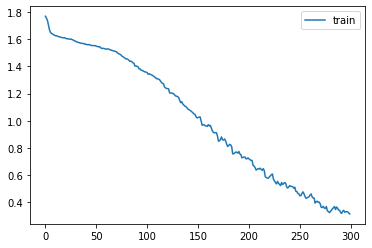

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### **5.7 Optional Building Model from Saved Weights**

In [ ]:
model = build_model(rnn_units_categorical, seq_length_categorical)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir_categorical))

IndexError: ignored

# **6 TESTING THE MODEL**

### **6.1 SIMPLE SINGLE DATA CHECKING**

<html>
<head>
<h1>SoftMax Activation Function on Categorical Ouput Data</b></h1>

<img src="https://i.ibb.co/HhM6t8z/softmax.webp" alt="softmax" border="0">
<img src="https://i.ibb.co/Fs8vKnS/softmax-activation-function.jpg" alt="softmax-activation-function" border="0">
</head>

<html>

In [ ]:
x_test = []
comparison_point = -5356
for x in range(seq_length_categorical,len(dpriceVector[0:comparison_point])):
  x_test.append(dpriceVector[x-seq_length_categorical:x])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_price_movements = model.predict(x_test)
softmax_results = tf.nn.softmax(predicted_price_movements)
print(softmax_results[-1])
predicted_move = tf.random.categorical(predicted_price_movements, num_samples=1)[-1,0].numpy()
print(predicted_move)
print(dpriceVector[comparison_point - 1])
# FOR REFERENCE
#0 - Big Move Down (:-2]
#1 - Medium Move Down (-2:-0.75]
#2 - Small Move Down (-0.75:0)
#3 - Small Move Up (0:0.75) 
#4 - Medium Move Up [0.75:2)
#5 - Big Move Up [2:)
#6 - No Movement

tf.Tensor(
[8.5012972e-02 8.8218480e-01 3.3901681e-03 2.1644976e-02 7.4516595e-03
 2.9120027e-04 2.4225377e-05], shape=(7,), dtype=float32)
0
-0.10174


### **6.2 ACCURACY SCRIPT - LOOPING THROUGH TEST DATA**

In [ ]:
x_test = []
y_pred = []
y_true = []
high_cutoff = 0.97*np.std(trainingData)
medium_cutoff = 0.35*np.std(trainingData)
for x in range(seq_length_categorical,len(dpriceVector)):
  x_test.append(dpriceVector[x-seq_length_categorical:x])
for x in range(0, testData_len):
  if testData[x] <= -high_cutoff:
    y_true.append(0)
  elif testData[x] <= -medium_cutoff and testData[x] > -high_cutoff:
    y_true.append(1)
  elif testData[x] < 0 and testData[x] > -medium_cutoff:
    y_true.append(2)
  elif testData[x] > 0 and testData[x] < medium_cutoff:
    y_true.append(3)
  elif testData[x] >= medium_cutoff and testData[x] < high_cutoff:
    y_true.append(4)
  elif testData[x] >= high_cutoff:
    y_true.append(5)
  else:
    y_true.append(6)
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_price_movements = model.predict(x_test)
raw_test_predictions = predicted_price_movements[(split_point-seq_length_categorical):]
y_pred = [tf.random.categorical([predicted_category], num_samples=1).numpy() for predicted_category in raw_test_predictions]

### **6.3 CONFIDENCE PREDICTIONS**

To utilize the confidence metric produced by the model for each prediction, we run a script to build a predicted array of predictions with >90% confidence and see if has better accuracy than trying to predict the next price at every price point. To this effect, it would be much more useful as a trading tool that could be used alongside other indicators to predict where the market is heading.

In [ ]:
x_test = []
y_pred = []
y_true_full = []
y_true = []
high_cutoff = 0.97*np.std(trainingData)
medium_cutoff = 0.35*np.std(trainingData)
for x in range(seq_length_categorical,len(dpriceVector)):
  x_test.append(dpriceVector[x-seq_length_categorical:x])
for x in range(0, testData_len):
  if testData[x] <= -high_cutoff:
    y_true_full.append(0)
  elif testData[x] <= -medium_cutoff and testData[x] > -high_cutoff:
    y_true_full.append(1)
  elif testData[x] < 0 and testData[x] > -medium_cutoff:
    y_true_full.append(2)
  elif testData[x] > 0 and testData[x] < medium_cutoff:
    y_true_full.append(3)
  elif testData[x] >= medium_cutoff and testData[x] < high_cutoff:
    y_true_full.append(4)
  elif testData[x] >= high_cutoff:
    y_true_full.append(5)
  else:
    y_true_full.append(6)
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_price_movements = model.predict(x_test)
raw_test_predictions = predicted_price_movements[(split_point-seq_length_categorical):]
softmaxed_predictions = tf.nn.softmax(raw_test_predictions)
for i in range(0,len(softmaxed_predictions)):
  if (np.amax(softmaxed_predictions[i]) > 0.90):
    y_pred.append(tf.random.categorical([softmaxed_predictions[i]], num_samples=1).numpy())
    y_true.append(y_true_full[i])

### **6.3 MODEL ACCURACY**

In [ ]:
#MODEL ACCURACY
num_correct = 0;
for i in range(0, len(y_pred)):
  if y_pred[i] == y_true[i]:
    num_correct +=1 

print("TOTAL CORRECT:",num_correct)
print("TOTAL DATA:", len(y_pred))
print("Accuracy:", num_correct/len(y_pred))

#RANDOM CHOICE ACCURACY
num_correct = 0;
for i in range(0,len(y_pred)):
  if y_true[i] == random.randint(0,6):
    num_correct += 1
print("TOTAL CORRECT:",num_correct)
print("TOTAL DATA:", len(y_pred))
print("Accuracy:", num_correct/len(y_pred))

TOTAL CORRECT: 164
TOTAL DATA: 1070
Accuracy: 0.15327102803738318
TOTAL CORRECT: 139
TOTAL DATA: 1070
Accuracy: 0.12990654205607477


### **6.4 CONFUSION MATRIX AND OTHER METRICS**

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.17      0.18      0.17        11
           2       0.17      0.09      0.12        11
           3       0.00      0.00      0.00        10
           4       0.38      0.27      0.32        11
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         0

    accuracy                           0.14        51
   macro avg       0.14      0.11      0.12        51
weighted avg       0.17      0.14      0.15        51



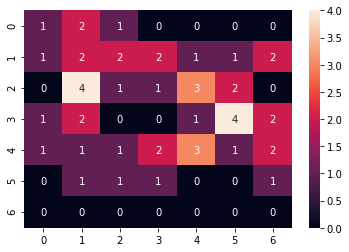

In [ ]:
cf_matrix = confusion_matrix(y_true, np.squeeze(y_pred))
sns.heatmap(cf_matrix, annot=True)
print(classification_report(y_true, np.squeeze(y_pred)))